To Build a :
- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN
- Network with L2 + BN


## Importing Libraries

In [1]:
# import model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np 

## Downloading DataSet


In [2]:
torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
bs = 256

train_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=True, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, shuffle=True, **kwargs
)

test_set = torch.utils.data.DataLoader(
    datasets.MNIST('../data/', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=bs, **kwargs
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining the model


In [3]:
import model


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = model.Net().to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 24, 28, 28]           1,728
       BatchNorm2d-6           [-1, 24, 28, 28]              48
              ReLU-7           [-1, 24, 28, 28]               0
         Dropout2d-8           [-1, 24, 28, 28]               0
         MaxPool2d-9           [-1, 24, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             192
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Training the network


In [6]:
def train(model, device, train_loader, optimizer, use_l1, lambda_l1):
    model.train() # training model
    pbar = tqdm(train_loader)
    t_acc = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # optimizer
        output = model(data) # output of the model

        loss = F.nll_loss(output, target) # calculate the loss
        l1 = 0
        if use_l1:
          for p in model.parameters():
            l1 = l1+ p.abs().sum()
        loss = loss+ lambda_l1*l1
        loss.backward() # backpropogation
        optimizer.step() # optimization

        pred = output.argmax(dim=1).eq(target).sum().item() # final prediction
        t_acc += pred # accuracy
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}') # setting the output
    
    return loss.item(), t_acc / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # output of the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # printing the loss and accuracy of test
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct/len(test_loader.dataset)

In [7]:
def fit(net, lr ,num_epoch, use_l1, use_l2=False, lambda_l1=0.05):
  if use_l2:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4) # SGD optimizer
  else:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

  # defining the dictionary for train and test, loss and accuracy
  h = dict() 
  h['train_loss'] = list()
  h['train_accuracy'] = list()
  h['test_loss'] = list()
  h['test_accuracy'] = list()

  for epoch in range(1, num_epoch+1):
      print(epoch)
      train_loss, train_acc = train(net, device, train_set, optimizer, use_l1, lambda_l1) # calling the training
      test_loss, test_acc = test(net, device, test_set) # calling the testing

      h['train_loss'].append(train_loss) # storing the training loss
      h['train_accuracy'].append(train_acc) # storing  the accuracy

      h['test_loss'].append(test_loss) # storing the testing loss
      h['test_accuracy'].append(test_acc) # storing the testing accuracy
  return net, h

### Batch Normalisation

In [9]:
net_bn, hist_bn = fit(model.Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.5235 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.51it/s]


Test set: Average loss: 0.3103, Accuracy: 9531/10000 (95.31%)

2


loss=0.1892 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


Test set: Average loss: 0.1138, Accuracy: 9757/10000 (97.57%)

3


loss=0.1965 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.62it/s]


Test set: Average loss: 0.0794, Accuracy: 9794/10000 (97.94%)

4


loss=0.1218 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.47it/s]


Test set: Average loss: 0.0615, Accuracy: 9841/10000 (98.41%)

5


loss=0.1286 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.37it/s]


Test set: Average loss: 0.0554, Accuracy: 9833/10000 (98.33%)

6


loss=0.1022 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.39it/s]


Test set: Average loss: 0.0449, Accuracy: 9868/10000 (98.68%)

7


loss=0.0548 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]


Test set: Average loss: 0.0422, Accuracy: 9867/10000 (98.67%)

8


loss=0.1150 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.42it/s]


Test set: Average loss: 0.0378, Accuracy: 9885/10000 (98.85%)

9


loss=0.1025 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.45it/s]


Test set: Average loss: 0.0356, Accuracy: 9888/10000 (98.88%)

10


loss=0.0735 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s]


Test set: Average loss: 0.0313, Accuracy: 9905/10000 (99.05%)

11


loss=0.1597 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.42it/s]


Test set: Average loss: 0.0307, Accuracy: 9907/10000 (99.07%)

12


loss=0.0999 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.43it/s]


Test set: Average loss: 0.0322, Accuracy: 9896/10000 (98.96%)

13


loss=0.0527 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.34it/s]


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

14


loss=0.1292 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.36it/s]


Test set: Average loss: 0.0302, Accuracy: 9904/10000 (99.04%)

15


loss=0.0584 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.40it/s]


Test set: Average loss: 0.0302, Accuracy: 9903/10000 (99.03%)

16


loss=0.1941 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s]


Test set: Average loss: 0.0280, Accuracy: 9912/10000 (99.12%)

17


loss=0.0230 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.43it/s]


Test set: Average loss: 0.0275, Accuracy: 9908/10000 (99.08%)

18


loss=0.0366 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.26it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

19


loss=0.0597 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.25it/s]


Test set: Average loss: 0.0300, Accuracy: 9897/10000 (98.97%)

20


loss=0.0383 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.28it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)



### Group Normalisation

In [19]:
net_gn, hist_gn = fit(model.Net(norm='gn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.6105 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.13it/s]


Test set: Average loss: 0.4913, Accuracy: 8913/10000 (89.13%)

2


loss=0.2235 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.07it/s]


Test set: Average loss: 0.1948, Accuracy: 9492/10000 (94.92%)

3


loss=0.0770 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


Test set: Average loss: 0.0955, Accuracy: 9748/10000 (97.48%)

4


loss=0.1964 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]


Test set: Average loss: 0.0697, Accuracy: 9790/10000 (97.90%)

5


loss=0.1126 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 0.0571, Accuracy: 9824/10000 (98.24%)

6


loss=0.1545 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.07it/s]


Test set: Average loss: 0.0503, Accuracy: 9854/10000 (98.54%)

7


loss=0.0906 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0477, Accuracy: 9862/10000 (98.62%)

8


loss=0.1409 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.01it/s]


Test set: Average loss: 0.0511, Accuracy: 9849/10000 (98.49%)

9


loss=0.1277 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]


Test set: Average loss: 0.0434, Accuracy: 9862/10000 (98.62%)

10


loss=0.0832 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


Test set: Average loss: 0.0366, Accuracy: 9881/10000 (98.81%)

11


loss=0.0679 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 0.0343, Accuracy: 9888/10000 (98.88%)

12


loss=0.0946 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


Test set: Average loss: 0.0308, Accuracy: 9897/10000 (98.97%)

13


loss=0.1041 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Test set: Average loss: 0.0328, Accuracy: 9897/10000 (98.97%)

14


loss=0.0450 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.11it/s]


Test set: Average loss: 0.0349, Accuracy: 9894/10000 (98.94%)

15


loss=0.1297 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.05it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

16


loss=0.1363 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0313, Accuracy: 9896/10000 (98.96%)

17


loss=0.0443 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.07it/s]


Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.09%)

18


loss=0.0396 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

19


loss=0.0553 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.09it/s]


Test set: Average loss: 0.0260, Accuracy: 9920/10000 (99.20%)

20


loss=0.0783 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)



### Layer Normalisation

In [20]:
net_ln, hist_ln = fit(model.Net(norm='ln').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=False)

1


loss=0.8332 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Test set: Average loss: 0.5979, Accuracy: 8384/10000 (83.84%)

2


loss=0.4041 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.2195, Accuracy: 9452/10000 (94.52%)

3


loss=0.3324 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.09it/s]


Test set: Average loss: 0.1293, Accuracy: 9653/10000 (96.53%)

4


loss=0.1859 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0889, Accuracy: 9740/10000 (97.40%)

5


loss=0.2696 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0861, Accuracy: 9760/10000 (97.60%)

6


loss=0.1182 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.11it/s]


Test set: Average loss: 0.0611, Accuracy: 9805/10000 (98.05%)

7


loss=0.2173 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.21it/s]


Test set: Average loss: 0.0555, Accuracy: 9821/10000 (98.21%)

8


loss=0.1880 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.07it/s]


Test set: Average loss: 0.0660, Accuracy: 9817/10000 (98.17%)

9


loss=0.0596 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]


Test set: Average loss: 0.0476, Accuracy: 9859/10000 (98.59%)

10


loss=0.1239 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0467, Accuracy: 9850/10000 (98.50%)

11


loss=0.0518 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Test set: Average loss: 0.0416, Accuracy: 9869/10000 (98.69%)

12


loss=0.1071 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]


Test set: Average loss: 0.0388, Accuracy: 9879/10000 (98.79%)

13


loss=0.0785 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Test set: Average loss: 0.0390, Accuracy: 9892/10000 (98.92%)

14


loss=0.0908 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]


Test set: Average loss: 0.0360, Accuracy: 9896/10000 (98.96%)

15


loss=0.1121 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]


Test set: Average loss: 0.0366, Accuracy: 9891/10000 (98.91%)

16


loss=0.1057 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.09it/s]


Test set: Average loss: 0.0323, Accuracy: 9898/10000 (98.98%)

17


loss=0.0289 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.18it/s]


Test set: Average loss: 0.0346, Accuracy: 9894/10000 (98.94%)

18


loss=0.1107 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Test set: Average loss: 0.0330, Accuracy: 9906/10000 (99.06%)

19


loss=0.1206 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]


Test set: Average loss: 0.0320, Accuracy: 9905/10000 (99.05%)

20


loss=0.0282 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)



### Batch Normalisation and L1

In [21]:
net_ln, hist_l1 = fit(model.Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=True, use_l2=False)

1


loss=2.7508 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 2.3026, Accuracy: 1010/10000 (10.10%)

2


loss=2.6772 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 2.3026, Accuracy: 958/10000 (9.58%)

3


loss=2.6761 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

4


loss=2.6793 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

5


loss=2.6754 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Test set: Average loss: 2.3026, Accuracy: 982/10000 (9.82%)

6


loss=2.6779 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

7


loss=2.6783 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.83it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

8


loss=2.6784 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

9


loss=2.6750 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Test set: Average loss: 2.3025, Accuracy: 1010/10000 (10.10%)

10


loss=2.6734 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 13.01it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

11


loss=2.6769 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Test set: Average loss: 2.3025, Accuracy: 1010/10000 (10.10%)

12


loss=2.6747 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.78it/s]


Test set: Average loss: 2.3025, Accuracy: 980/10000 (9.80%)

13


loss=2.6768 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

14


loss=2.6814 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

15


loss=2.6767 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Test set: Average loss: 2.3026, Accuracy: 892/10000 (8.92%)

16


loss=2.6795 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.92it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

17


loss=2.6753 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

18


loss=2.6775 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

19


loss=2.6800 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.89it/s]


Test set: Average loss: 2.3026, Accuracy: 1032/10000 (10.32%)

20


loss=2.6762 batch_id=234: 100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11.35%)



### Batch Normalisation and L2

In [22]:
net_ln, hist_l2 = fit(model.Net(norm='bn').to(device), lr=0.01, num_epoch=20, use_l1=False, use_l2=True)

1


loss=0.7267 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]


Test set: Average loss: 0.4337, Accuracy: 9346/10000 (93.46%)

2


loss=0.2254 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.34it/s]


Test set: Average loss: 0.1487, Accuracy: 9666/10000 (96.66%)

3


loss=0.1745 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.47it/s]


Test set: Average loss: 0.0879, Accuracy: 9769/10000 (97.69%)

4


loss=0.1977 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.42it/s]


Test set: Average loss: 0.0689, Accuracy: 9811/10000 (98.11%)

5


loss=0.1042 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.45it/s]


Test set: Average loss: 0.0582, Accuracy: 9829/10000 (98.29%)

6


loss=0.1165 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.46it/s]


Test set: Average loss: 0.0531, Accuracy: 9848/10000 (98.48%)

7


loss=0.1453 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.31it/s]


Test set: Average loss: 0.0475, Accuracy: 9844/10000 (98.44%)

8


loss=0.1080 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.40it/s]


Test set: Average loss: 0.0420, Accuracy: 9877/10000 (98.77%)

9


loss=0.0724 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


Test set: Average loss: 0.0417, Accuracy: 9884/10000 (98.84%)

10


loss=0.0466 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]


Test set: Average loss: 0.0396, Accuracy: 9874/10000 (98.74%)

11


loss=0.1123 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.43it/s]


Test set: Average loss: 0.0361, Accuracy: 9882/10000 (98.82%)

12


loss=0.0876 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]


Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

13


loss=0.1524 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.36it/s]


Test set: Average loss: 0.0328, Accuracy: 9896/10000 (98.96%)

14


loss=0.0760 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]


Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.96%)

15


loss=0.1251 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.41it/s]


Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

16


loss=0.0891 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.40it/s]


Test set: Average loss: 0.0309, Accuracy: 9899/10000 (98.99%)

17


loss=0.0768 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.38it/s]


Test set: Average loss: 0.0292, Accuracy: 9915/10000 (99.15%)

18


loss=0.0695 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.35it/s]


Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

19


loss=0.1074 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.58it/s]


Test set: Average loss: 0.0311, Accuracy: 9909/10000 (99.09%)

20


loss=0.1171 batch_id=234: 100%|██████████| 235/235 [00:17<00:00, 13.35it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)



## Plotting the Loss curve and Accuracy for different EPOCHS



In [10]:
def plot_history(h, norm):
  # Ploting the graphs for loss and accuracy 
  # For loss and epochs
  plt.figure(figsize=(14,5))
  plt.title(norm)
  
  plt.subplot(1,2,1)
  plt.plot(h['train_loss'], label='Training Loss') # plotting the training loss
  plt.plot(h['test_loss'], label='Test Loss') # plotting the testing loss
  # putting the labels on plot
  plt.title('Loss vs Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  # For accuracy and epochs
  plt.subplot(1,2,2)
  plt.plot(h['train_accuracy'], label='Training Accuracy') # plotting the training accuracy
  plt.plot(h['test_accuracy'], label='Test Accuracy') # plotting the testing accuracy
  # putting the labels in plot
  plt.title('Accuracy vs Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()

  plt.show()

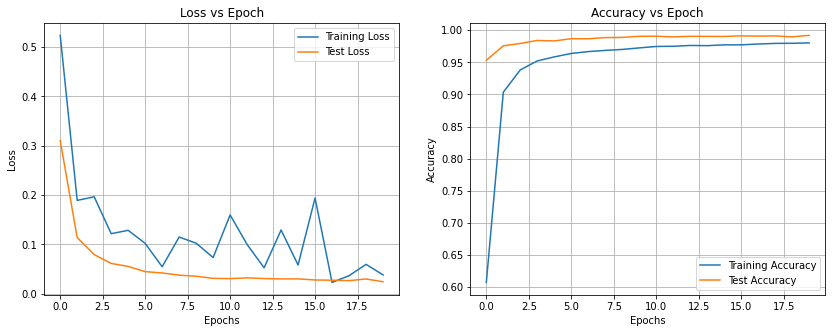

In [11]:
# Plot for Batch Normalisation
plot_history(hist_bn, norm = 'bn')

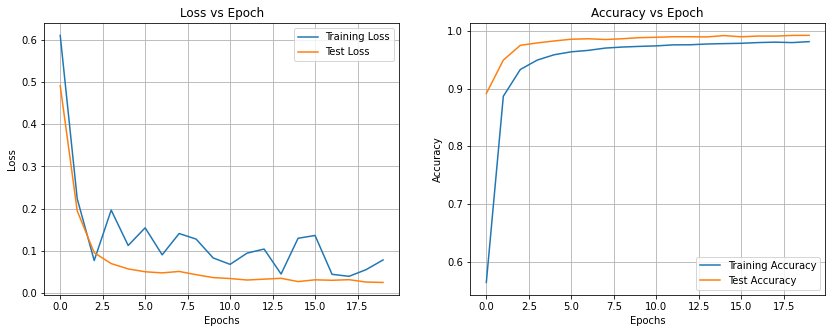

In [23]:
# Plot for Group Normalisation
plot_history(hist_gn, norm = 'gn')

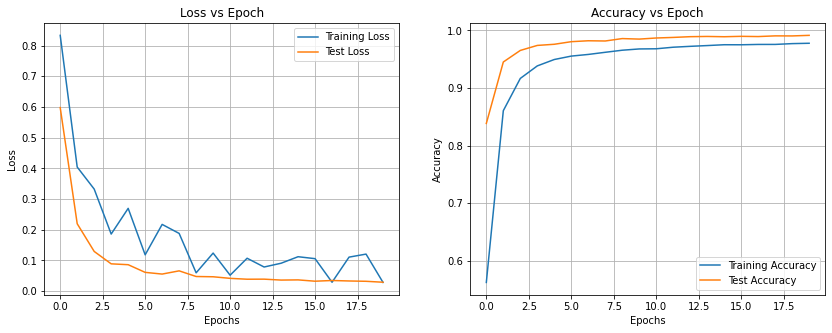

In [24]:
# Plot for Layer Normalisation
plot_history(hist_ln, norm = 'ln')

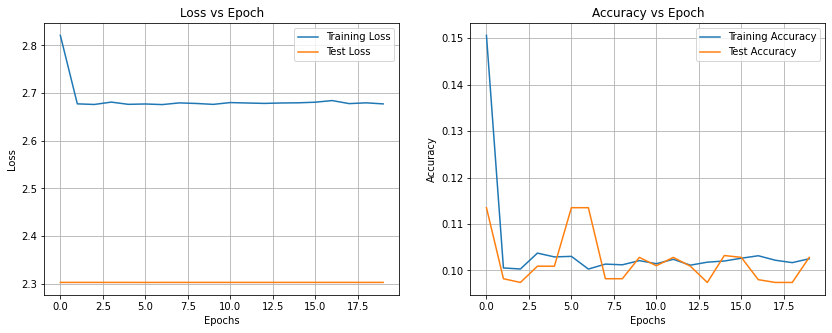

In [ ]:
# Plot for Batch Normalisation + L1
plot_history(hist_l1, norm = 'bn')

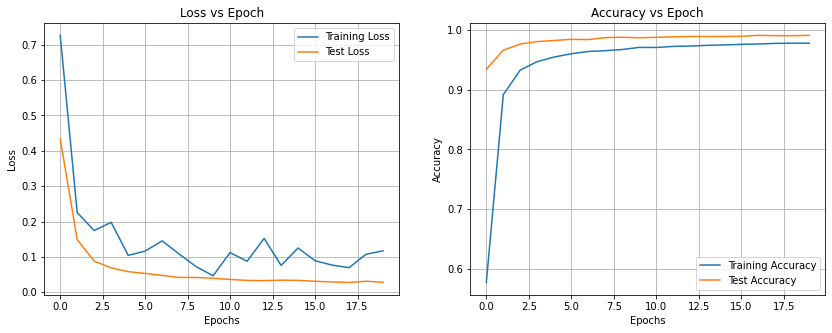

In [25]:
# Plot for Batch Normalisation + L2
plot_history(hist_l2, norm = 'bn')

In [26]:
### Visualising the misclassified Data while using Batch Normalisation

In [27]:
def plot_misclassified(net, data_loader, plot_title, num_images=20, row=4, col=5):
  count = 0
  k = 0
  row, col = row, col
  fig = plt.figure(figsize=(col*2, row*3))
  while count<num_images:
    img, label = data_loader.dataset[k]
    pred = net(img.unsqueeze(0).to(device)).argmax().item()

    if pred!=label:
      count+=1
      fig.add_subplot(row, col, count)
      plt.suptitle(plot_title)
      plt.title(f"Ground Truth :{label}\n Prediction: {pred}")
      plt.imshow(img.squeeze(0), cmap='gray')
      plt.axis('off')
    k += 1
  plt.tight_layout()
  plt.show()


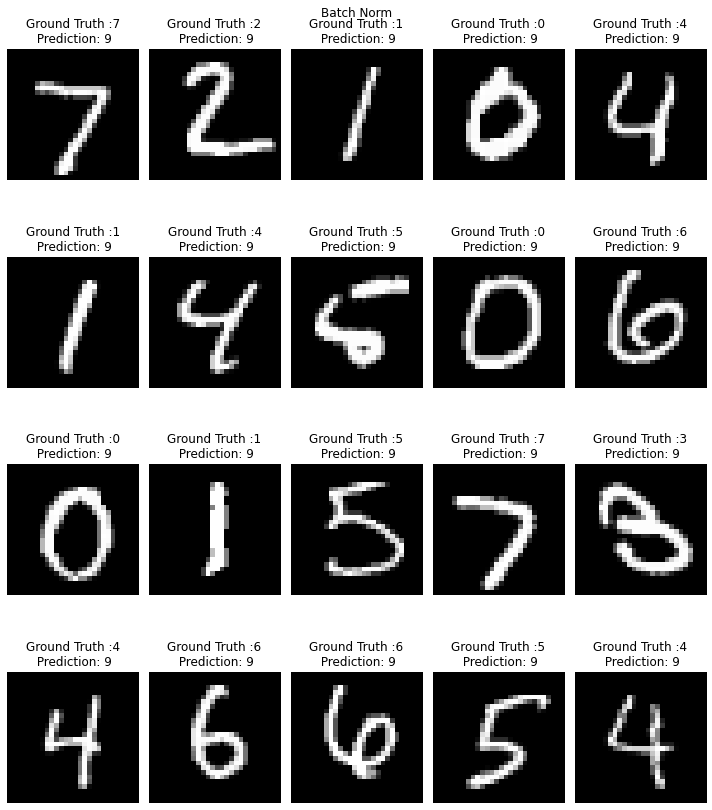

In [16]:
plot_misclassified(model.Net(norm='bn').to(device), test_set, plot_title='Batch Norm')

In [ ]:
### Visualising the classified Data while using Batch Normalisation

In [17]:
def plot_classified(net, data_loader, plot_title, num_images=20, row=4, col=5):
  count = 0
  k = 0
  row, col = row, col
  fig = plt.figure(figsize=(col*2, row*3))
  while count<num_images:
    img, label = data_loader.dataset[k]
    pred = net(img.unsqueeze(0).to(device)).argmax().item()

    if pred ==label:
      count+=1
      fig.add_subplot(row, col, count)
      plt.suptitle(plot_title)
      plt.title(f"Ground Truth :{label}\n Prediction: {pred}")
      plt.imshow(img.squeeze(0), cmap='gray')
      plt.axis('off')
    k += 1
  plt.tight_layout()
  plt.show()

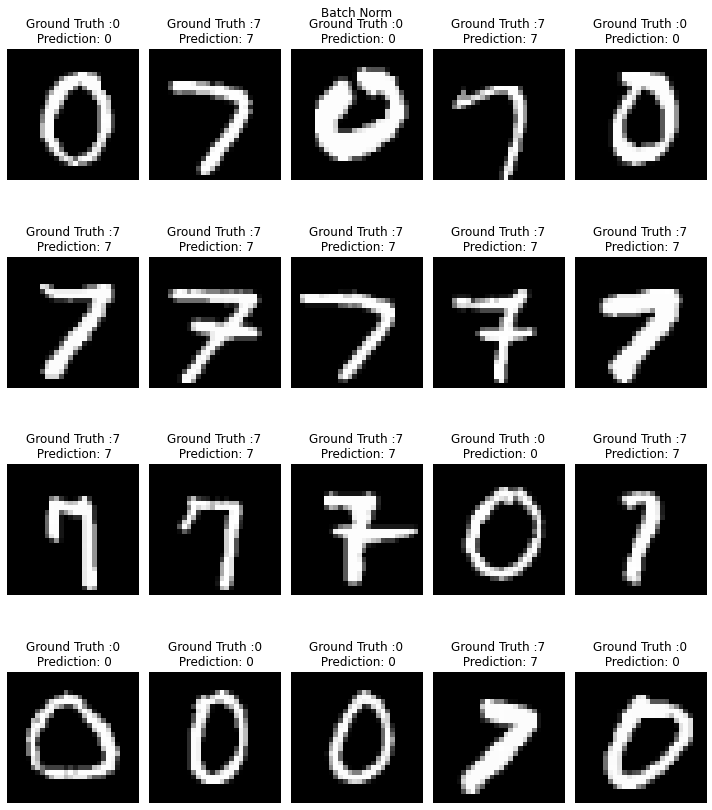

In [18]:
plot_classified(model.Net(norm='bn').to(device), test_set, plot_title='Batch Norm')